# ADCP Example

The following example shows a typical workflow for analyzing ADCP data using DOLfYN's tools.

Start by importing the necessary DOLfYN tools:

In [1]:
import dolfyn as dlfn
import dolfyn.adp.api as apm

## Read Raw Instrument Data

The core benefit of DOLfYN is that it can read in raw data directly after transferring it off of the ADCP. The instruments that DOLfYN supports are listed in the documentation. The ADCP used here is a Nortek Signature 1000, with the file extension '.ad2cp'. This specific dataset contains several hours worth of velocity data collected at 1 Hz from the ADCP mounted on a bottom lander in a tidal inlet. Depending on how large the file is, this could take a few minutes.

In [2]:
dat = dlfn.read_example('Sig1000_tidal.ad2cp') # use `dlfn.read([path to file + filename])` for your data
dat

Reading file c:\users\mcve343\dolfyn\dolfyn\example_data\Sig1000_tidal.ad2cp ...


<xarray.Dataset>
Dimensions:              (dir: 4, dirIMU: 3, earth: 3, inst: 3, q: 4, range: 28, range_b5: 28, time: 73151, time_b5: 73151, x: 4, x*: 4)
Coordinates:
  * time                 (time) float64 1.597e+09 1.597e+09 ... 1.597e+09
  * dirIMU               (dirIMU) <U1 'E' 'N' 'U'
  * time_b5              (time_b5) float64 1.597e+09 1.597e+09 ... 1.597e+09
  * range_b5             (range_b5) float64 0.6 1.1 1.6 2.1 ... 13.1 13.6 14.1
  * dir                  (dir) <U2 'E' 'N' 'U1' 'U2'
  * range                (range) float64 0.6 1.1 1.6 2.1 ... 12.6 13.1 13.6 14.1
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * earth                (earth) <U1 'E' 'N' 'U'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
Data variables:
    c_sound              (time) float32 1.496e+03 1.496e+03 ... 1.497e+03
    temp                 (time) float32 12.79 12.79 12.79 ... 13.01 13.0 13.0
    pressure             (time) float32 9.425 9.432 9.428 ... 8.724 8.727 8.721
    mag                  (dirIMU, time) float32 71.5 71.8 71.4 ... -197.1 -197.4
    accel                (dirIMU, time) float32 0.00958 0.02874 ... 9.705 9.705
    vel                  (dir, range, time) float32 -0.007 0.002 ... -0.037
    amp                  (dir, range, time) float16 80.0 80.0 77.5 ... 42.0 42.0
    corr                 (dir, range, time) uint8 96 98 82 84 ... 99 100 89 92
    orientmat            (inst, earth, time) float32 -0.2099 -0.21 ... 0.9914
    angrt                (dirIMU, time) float32 -0.00293 ... -0.0009766
    quaternion           (q, time) float32 0.6272 0.6271 0.627 ... 0.7791 0.7791
    mag_b5               (dirIMU, time_b5) float32 71.4 71.8 ... -197.1 -196.5
    accel_b5             (dirIMU, time_b5) float32 0.02395 0.02395 ... 9.719
    vel_b5               (range_b5, time_b5) float32 -0.005 -0.015 ... 0.062
    amp_b5               (range_b5, time_b5) float16 79.0 79.5 ... 41.0 41.5
    corr_b5              (range_b5, time_b5) uint8 93 100 93 99 ... 93 98 95 95
    orientmat_b5         (inst, earth, time_b5) float32 -0.2099 ... 0.9914
    angrt_b5             (dirIMU, time_b5) float32 -0.001953 ... -0.00293
    quaternion_b5        (q, time_b5) float32 0.6272 0.6272 ... 0.7791 0.7791
    heading              (time) float32 -12.12 -12.12 -12.15 ... -12.67 -12.67
    pitch                (time) float32 0.23 0.21 0.22 ... -0.07 -0.07 -0.07
    roll                 (time) float32 -7.665 -7.67 -7.68 ... -7.53 -7.52 -7.53
    beam2inst_orientmat  (x, x*) float32 1.183 0.0 -1.183 ... 0.5518 0.0 0.5518
Attributes:
    filehead_config:    {'CLOCKSTR': {'TIME': '"2020-08-13 13:56:21"'}, 'ID':...
    inst_model:         Signature1000
    inst_make:          Nortek
    inst_type:          ADCP
    rotate_vars:        ['vel', 'accel', 'accel_b5', 'angrt', 'angrt_b5', 'ma...
    burst_config:       {'press_valid': True, 'temp_valid': True, 'compass_va...
    ncells:             28
    nbeams:             4
    xmit_energy:        245.0
    ambig_vel:          5.055
    SerialNum:          101663
    cell_size:          0.5
    blank_dist:         0.1
    burst_config_b5:    {'press_valid': True, 'temp_valid': True, 'compass_va...
    ncells_b5:          28
    coord_sys_axes_b5:  beam
    nbeams_b5:          1
    xmit_energy_b5:     65.0
    ambig_vel_b5:       5.055
    SerialNum_b5:       101663
    cell_size_b5:       0.5
    blank_dist_b5:      0.1
    coord_sys:          earth
    orientation:        AHRS
    orient_status:      AHRS-3D
    has_imu:            1
    fs:                 1

Simply type the variable to show its contents. ADCP's record three main types of data: the measured velocity, amplitude, and correlation. The latter two are measures of acoustic backscatter and the return signal quality, respectively. The dataset will also contain orientation data that DOLfYN uses to rotate the dataset through the proper coordinate systems.

## First Steps and QC'ing Data

Because this is a Nortek instrument, Nortek deployment software doesn't take into account where in the water column the ADCP actually is. Before going any farther, let's adjust the depth bin locations for that:

In [3]:
# correct the range so that '0' corresponds to the seafloor
# the ADCP transducers were measured to be 0.6 m from the feet of the tripod it was mounted on.
dat = apm.clean.set_deploy_altitude(dat, 0.6)
dat.range

<xarray.DataArray 'range' (range: 28)>
array([ 1.2,  1.7,  2.2,  2.7,  3.2,  3.7,  4.2,  4.7,  5.2,  5.7,  6.2,  6.7,
        7.2,  7.7,  8.2,  8.7,  9.2,  9.7, 10.2, 10.7, 11.2, 11.7, 12.2, 12.7,
       13.2, 13.7, 14.2, 14.7])
Coordinates:
  * range    (range) float64 1.2 1.7 2.2 2.7 3.2 ... 12.7 13.2 13.7 14.2 14.7
Attributes:
    units:    m

To reduce the amount of data we need to work with, we can remove all data at and above the water surface. This does require that the pressure sensor was 'zeroed' prior to deployment. If the instrument is down-facing, there is another function available for bottom-detection.

In [4]:
# Most instruments record pressure data, but not all record the water salinity
dat = apm.clean.surface_from_P(dat, salinity=31)
# The surface level is stored in the variable `d_range`
dat = apm.clean.nan_beyond_surface(dat)

Once the extra bins above the surface have been cleared away, the final standard filtering for ADCP data is a raw correlation filter to filter out spurious velocity datapoints (from bubbles, kelp, fish, etc). 
Since this instrument is located in an estaury tidal channel, which usually have ideal turbidity levels for acoustic Doppler measurements, we set the filter to screen data with a correlation below 70 (in this case in units of '%'). Note that this value is dependent on the deployment environment and instrument.

In [7]:
# set correlation below 70% to NaN
dat = apm.clean.correlation_filter(dat, thresh=70)

## Current Velocities

Now that the data has been cleaned, the next step is to rotate the velocity data into true East, North, Up coordinates:

In [8]:
# First, set the magnetic declination to that of where the data was collected
dat = dlfn.set_declination(dat, 15.8) # 15.8 deg East

# If the dataset wasn't already read in in 'earth' (ENU), coordinates, rotate it now.
dat = dlfn.rotate2(dat, 'earth')

Data is already in the earth coordinate system


Because this deployment was set up in 'burst mode' (as opposed to an 'averaging mode') the next standard step in this analysis is to average the velocity data into time bins. If an instrument was set up to record velocity data with a specific profiling and averaging interval (e.g. take 1 minute of data every 10 minutes), this step was already done within the ADCP during deployment.

In [9]:
# To average the data into time bins (aka ensembles), start by initiating `VelBinner`
# n_bin is the number of data points in each ensemble, in this case 300 seconds
# fs is the sampling frequency, which is 1 Hz for this deployment
avg_tool = dlfn.VelBinner(n_bin=dat.fs*300, fs=dat.fs)

# Average the data into ensembles
dat_avg = avg_tool.do_avg(dat)

# For example, the bin-averaged horizontal velocity magnitude
dat_avg.Veldata.U_mag

<xarray.DataArray 'vel' (range: 28, time: 243)>
array([[0.06111779, 0.05959039, 0.05412581, ..., 0.6806742 , 0.67905893,
        0.66477135],
       [0.08173255, 0.07144974, 0.06740507, ..., 0.74660063, 0.7510398 ,
        0.73960358],
       [0.09421772, 0.07534399, 0.07622514, ..., 0.80763054, 0.81740364,
        0.79863756],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * range    (range) float64 1.2 1.7 2.2 2.7 3.2 ... 12.7 13.2 13.7 14.2 14.7
  * time     (time) float64 1.597e+09 1.597e+09 ... 1.597e+09 1.597e+09
Attributes:
    units:        m/s
    description:  horizontal velocity magnitude

## Plotting

The final step is to plot the data, to which matplotlib's `pcolormesh()` is recommended.

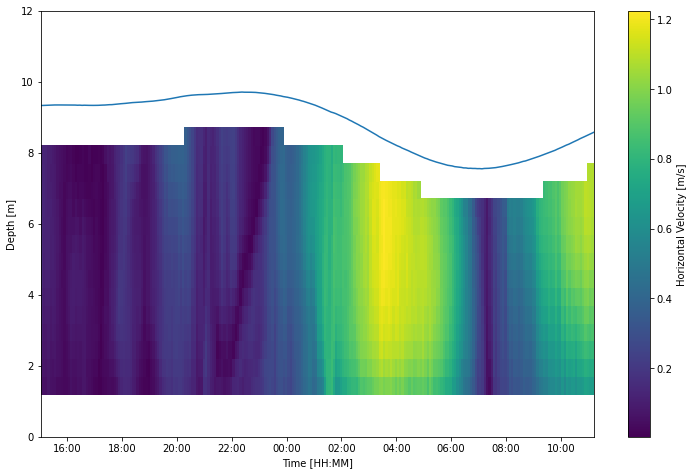

In [10]:
from matplotlib import pyplot as plt
import matplotlib.dates as dt

t = dlfn.time.epoch2date(dat_avg.time)

ax = plt.figure(figsize=(12,8)).add_axes([.14, .14, .8, .74])
# Plot the horizontal velocity
plt.pcolormesh(t, dat_avg.range, dat_avg.Veldata.U_mag)
# Plot the water surface
ax.plot(t, dat_avg.d_range)

# set up time on x-axis
ax.set_xlabel('Time [HH:MM]')
ax.xaxis.set_major_formatter(dt.DateFormatter('%H:%M'))

ax.set_ylabel('Depth [m]')
ax.set_ylim([0, 12]);
plt.colorbar(label='Horizontal Velocity [m/s]');